In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
# import LSTM_Train as LSTM
import LSTM

%matplotlib inline
%config IPCompleter.greedy=True
plt.rcParams["figure.figsize"] = (14, 8)

    N  T  MSE  STD
0  50  5  0.0  0.0
1   8  0  0.0  0.0
2  44  3  0.0  0.0
3  83  3  0.0  0.0
4  83  8  0.0  0.0
5  52  0  0.0  0.0
{'proc': 1, 'T_Max': 10, 'N_Max': 100, 'reps': 3, 'epochs': 50, 'Y': 'fch4', 'Searches': 2}


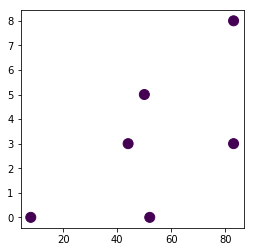

In [2]:
Runs,params = LSTM.Params('Test','fch4',MP=False)# rpms.Runs,rpms.params
Runs['MSE'] = 0.0
Runs['STD'] = 0.0
print(Runs)
print(params)
plt.figure(figsize = (4,4))
plt.scatter(Runs["N"],Runs['T'],s=100,c=Runs['MSE'])

(1737, 6, 12)
Finisehed Run  0
(1742, 1, 12)
Finisehed Run  1
(1739, 4, 12)
Finisehed Run  2
(1739, 4, 12)
Finisehed Run  3
(1734, 9, 12)
Finisehed Run  4
(1742, 1, 12)
Finisehed Run  5
    N  T       MSE       STD
0  50  5  0.795293  0.076086
1   8  0  0.607390  0.064647
2  44  3  0.583971  0.056855
3  83  3  0.578585  0.057171
4  83  8  0.601852  0.018806
5  52  0  0.461252  0.078088
310.1506278514862


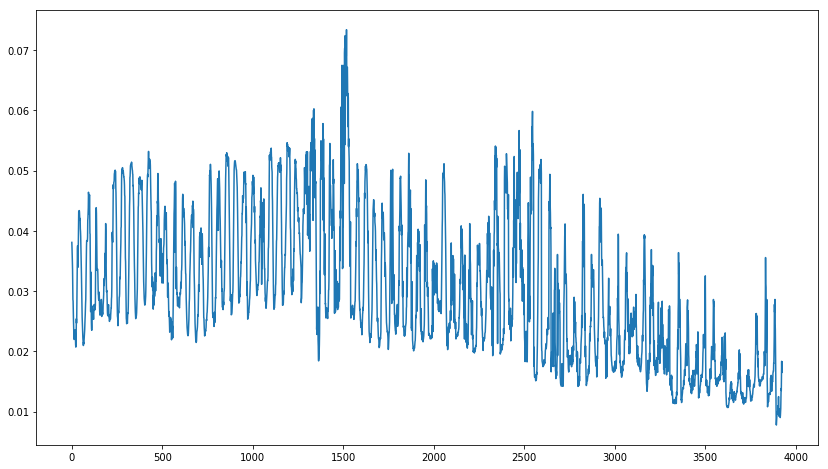

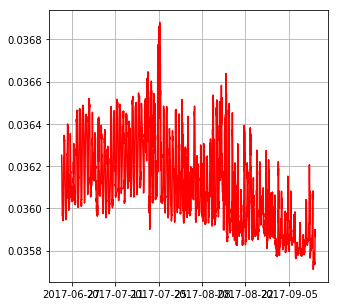

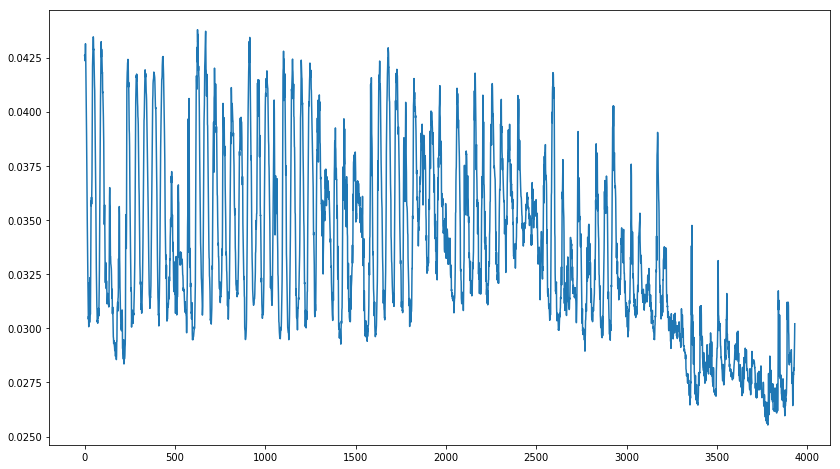

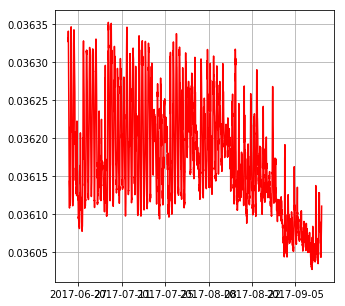

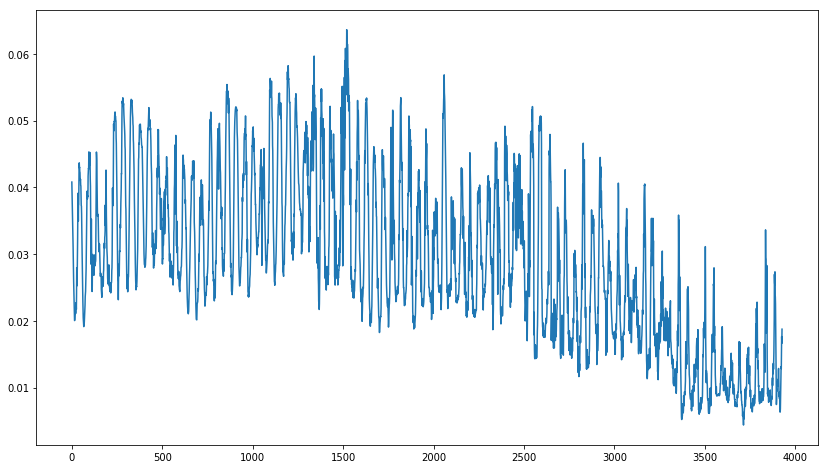

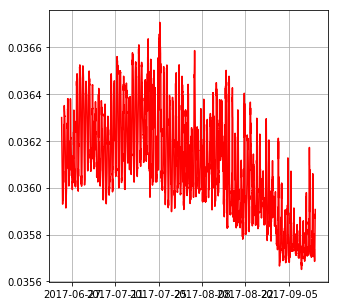

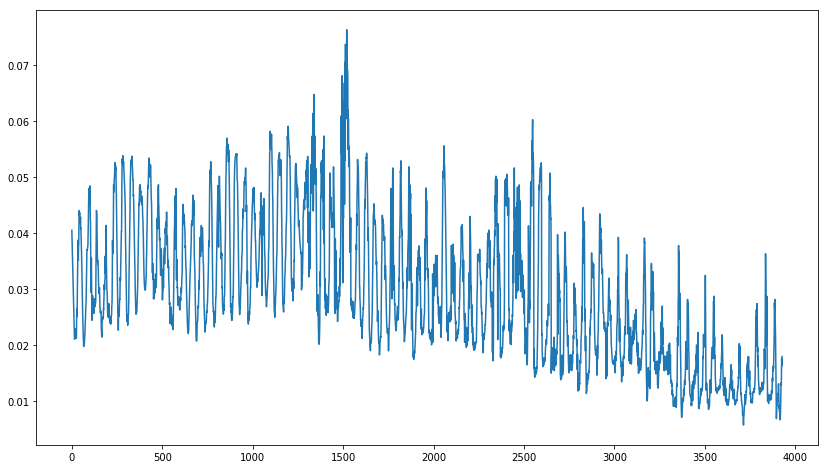

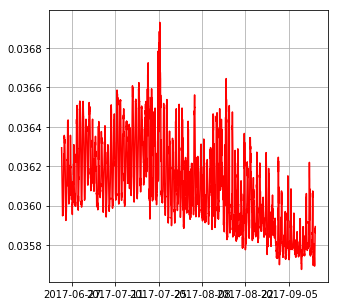

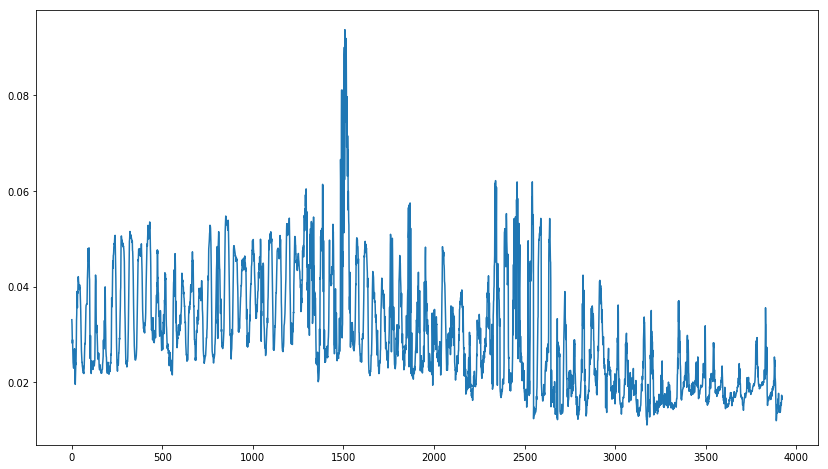

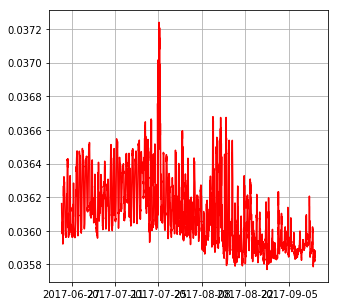

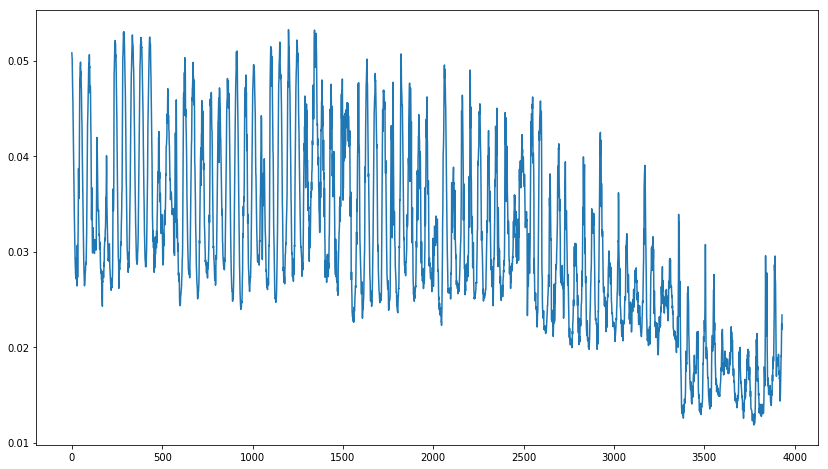

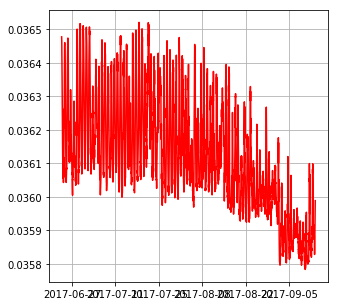

In [6]:
def TTV_Split(i,Memory,X,y,params,X_fill):
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=i)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=i)
    return(LSTM.Train_Steps(params['epochs'],params['N'],X_train,X_test,X_val,y_train,y_test,
                            y_val,i,X_fill = X_fill,Memory=Memory))


Full = ['H','LE','Fco2','fco2','fch4','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table','Ts 2.5 cm',
         'Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd','ET']

Model = ['H','Wind Spd','air pressure','Ta','Rn','PPFD','Ts 2.5 cm','Ts 15 cm',
         'VWC','Active Layer','24H Rain','Wtr Tbl Trnd']

Time = time.time()
Path = 'FilteredData2018-04-04.csv'

def RunReps(Model,Runs,params,pool = None,plot=True):
    RST = RSTF.ReadStandardTimeFill(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    RST.TimeShape(params['T'])
    y = RST.y_time.copy()#*1.0
    X = RST.X_time.copy()#*1.0
    X_fill = RST.X_ftime.copy()
    print(X.shape)
    MSE = []
    Y_fill = []
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params,X_fill=X_fill),
                                             range(params['reps']))):
            mse = results[0]
            y_fill = results[1]
            Y_fill.append(y_fill)
            MSE.append(mse)
    else:
        for i in range(params['reps']):
            results = TTV_Split(i,Memory,X,y,params,X_fill)
            mse = results[0]
            MSE.append(mse)
            y_fill = results[1]
            Y_fill.append(y_fill)
    MSE = np.asanyarray(MSE)
    Y_fill = np.asanyarray(Y_fill).mean(axis=0)
#     y = RST.YScaled.inverse_transform(y)
    Y_fill = RST.YScaled.inverse_transform(Y_fill)
#     plt.figure()
#     plt.plot(Y_fill)
    RST.Fill(Y_fill,'Fch4')
    if plot == True:
        plt.figure(figsize=(5,5))
        plt.plot(RST.Master['Fch4'],color='red')
        plt.plot(RST.Master['fch4'],color='grey')
#         plt.plot(RST.Master['TempFill'],color='blue')  # This works
        
        yl = plt.ylim()
#         plt.xlim(yl[0],yl[1])
        plt.grid()
    return(MSE)

if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
    
for i in Runs.index:
    params['T']=Runs['T'].iloc[i]
    params['N']=Runs['N'].iloc[i]
    MSE = RunReps(Model,Runs,params,pool)
    Runs['MSE'][i]=MSE.mean()
    Runs['STD'][i]=MSE.std()
    print('Finisehed Run ',str(i))

print(Runs)
print(time.time()-Time)
        

    N  T       MSE       STD
0  92  9  0.672136  0.030491
1  39  8  0.832460  0.078850
2  29  9  0.743279  0.034850
3  25  7  0.909554  0.290937
4  82  4  0.789571  0.024894
5  61  7  0.665243  0.136574


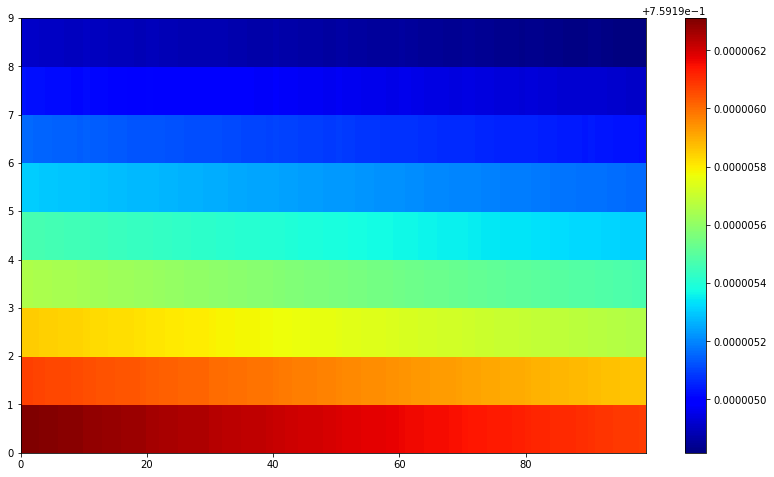

In [8]:
from scipy.stats import norm)


def upper_confidence_bound(mu_x, sigma_x, opt_value, kappa=-1.0):
    return mu_x + kappa * sigma_x

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

kernel = Matern(length_scale = [1,1],length_scale_bounds="fixed")
kernel = ConstantKernel(1e0, (1e-2, 1e2))*Matern(1e1, (1e-4, 1e4),nu = 2.5)\
+ WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-2, 1e2))

gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=0,normalize_y=True)
gp.fit(Runs[['N','T']].values, Runs['MSE'].values)

N = [n for n in range(params['N_Max'])]
T = [t for t in range(params['T_Max'])]
A = [T[i] for j in range(len(N))for i in range(len(T))]
B = [N[j] for j in range(len(N))for i in range(len(T))]
T = np.asanyarray(A)
N = np.asanyarray(B)

X = np.zeros(shape=(T.shape[0],2))
X[:,0] = N
X[:,1] = T

Xi = np.arange(N.min(),N.max()+.1,1)
Yi = np.arange(T.min(),T.max()+.1,1)
xi,yi = np.meshgrid(Xi,Yi)


y_pred,sigma = gp.predict(X,return_std=True)
y_predi = y_pred.reshape(xi.shape[0],xi.shape[1])

print(Runs)

plt.figure()
plt.pcolor(xi,yi,y_predi,cmap=cm.jet)
plt.colorbar()
# plt.legend()
Runs2 = Runs.copy()

In [9]:
from scipy.optimize import minimize
acq = upper_confidence_bound
def query(xi, yi, gp):
    best_value = np.inf

    for N in np.linspace(1,params['N_Max']):
        for T in np.linspace(0,params['T_Max']):
            def obj(x):
                x=x.reshape(1,-1)
                mu_x, sigma_x = gp.predict(x, return_std=True)
#                 print(np.min(yi),np.max(yi))
                return acq(mu_x, sigma_x, np.min(yi))
            x0 = np.asanyarray([N,T]).reshape(1,2)
            res = minimize(obj, x0, bounds=((1, params['N_Max']),(0,params['T_Max'])))

            if res.fun < best_value:
                best_value = res.fun
                query_point = res.x
    query_point = query_point
    return query_point

for i in range(params['Searches']):
#     kernel = Matern(length_scale_bounds="fixed") 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=1,normalize_y=True)
    gp.fit(Runs[['N','T']].values, Runs['MSE'].values)
    
    next_x = query(Runs[['N','T']].values, Runs['MSE'].values, gp)
    print(next_x)
    N = int(np.round(next_x[0],0))
    T = int(np.round(next_x[1],0))
    o = 0
    while len(Runs.loc[(Runs['N']==N) & (Runs['T']==T)].index) != 0:
        print('Adjust!')
        o +=1
        N += int(o*np.cos(o*np.pi))
    print(N,T)
    d = {'N':N,'T':T,'MSE':0,'STD':0}
    idx = Runs.index[-1] + 1
    D2 = pd.DataFrame(data=d,index=[idx])
    Runs = Runs.append(D2)
    
    MSE = RunReps(Model,Runs,params,pool)#RunFunc(i,processes=processes,Modz=Model,reps=reps,epochs=epochs,params=Runs)
    print(MSE)
    Runs['MSE'][idx]=MSE.mean()
    Runs['STD'][idx]=MSE.std()
    
    Runs = Runs.sort_values(by = ['N','T']).reset_index(drop=True)
    
print(Runs)


[ 100.    0.]
100 0
[ 0.79654736  0.52866972]
[ 100.    0.]
Adjust!
99 0
[ 0.80185319  0.52866972]
        MSE    N       STD  T
0  0.909554   25  0.290937  7
1  0.743279   29  0.034850  9
2  0.832460   39  0.078850  8
3  0.665243   61  0.136574  7
4  0.789571   82  0.024894  4
5  0.672136   92  0.030491  9
6  0.665261   99  0.136592  0
7  0.662609  100  0.133939  0


        MSE    N       STD  T
7  0.662609  100  0.133939  0


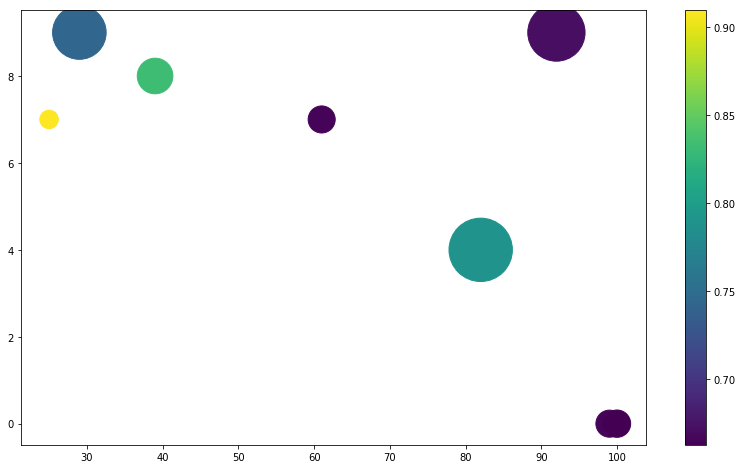

In [10]:
Optimum = Runs[Runs['MSE'] == Runs['MSE'].min()]
print(Optimum)
plt.figure()
plt.scatter(Runs["N"],Runs['T'],s=1/Runs['STD']*100,c=Runs['MSE'])
plt.colorbar()
# plt.legend()

In [ ]:
def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor == None:
            Models.append(c)
        else:
            if set(factor).issubset(set(c)):
#             if factor in c:
                Models.append(c)
    return(Models)
# print(params)
params['T']=Optimum['T'].values[0]
params['N']=Optimum['N'].values[0]
params['proc']=1
FullModel = ['H','Wind Spd','air pressure','Ta']#,
#          'Rn','PPFD','Ts 2.5 cm','Ts 15 cm',
#          'VWC','Active Layer','24H Rain','Wtr Tbl Trnd','ET']


BestMSE = []
idx = []
BestModels = []

for i in range(1,len(FullModel)+1):
    print('Level: ',i)
    if i == 1:
        Models = Combos(FullModel,i)
    else:
        Models = Combos(FullModel,i,factor = Best)
#     for model in Models:
    Score = []
    for model in Models:
        MSE = RunReps(model,Runs,params,pool)
        Score.append(MSE)
    Score = np.asanyarray(Score)
#         print(Score)
    Best = Models[np.where(Score == Score.min())[0][0]]
    BestModels.append(Best)
    BestMSE.append(Score.min())
    idx.append(i)
    print('Best:')
    print(Best,Score.min())
BestModels = np.asanyarray(BestModels)
BestMSE = np.asanyarray(BestMSE)
idx = np.asanyarray(idx)
plt.figure(figsize=(10,10))
plt.bar(idx,BestMSE)


if __name__=='__main__'and params['proc'] != 1:
    pool.close()